In [238]:
# Imports

# For displaying images
from IPython.display import Image 

# For plotting figures
import matplotlib.pyplot as plt
from matplotlib import gridspec

# For array and matrix data structures
import numpy as np

# For data manipulation and analysis
import pandas as pd

# For the confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# For computing the neural network and preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import *
from tensorflow.keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16

# Set Matplotlib defaults such that plots are bigger and labels are more clear
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
      titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

In [240]:
# Load in the training data
ds_train = image_dataset_from_directory(
    r'C:\Users\user\Desktop\ChessTSYP\input\train',
    labels = 'inferred',        # same labels as map labels
    label_mode = 'categorical',  # categorical data
    image_size=[224, 224],
    interpolation = 'nearest',  # used for small image size
    batch_size = 32,
    shuffle = True,             # classes are randomized
)

# Load in the validation data
ds_valid = image_dataset_from_directory(
    r'C:\Users\user\Desktop\ChessTSYP\input\valid',
    labels = 'inferred',        # same labels as map labels
    label_mode = 'categorical',  # categorical data
    image_size=[224, 224],
    interpolation = 'nearest',  # used for small image size
    batch_size = 32,
    shuffle = True,             # classes are randomized
)

# Load in the test data
ds_test = image_dataset_from_directory(
    r'C:\Users\user\Desktop\ChessTSYP\input\test',
    labels = 'inferred',        # same labels as map labels
    label_mode = 'categorical',  # categorical data
    image_size=[224, 224],
    interpolation = 'nearest',  # used for small image size
    batch_size = 32,
    shuffle = True,             # classes are randomized
)

Found 217 files belonging to 12 classes.
Found 47 files belonging to 12 classes.
Found 38 files belonging to 12 classes.


In [242]:
# Converting tf.uint8 to float to normilize images
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label
AUTOTUNE = tf.data.experimental.AUTOTUNE

# normilize images from the training data
ds_train = (ds_train.map(convert_to_float).cache().prefetch(buffer_size = AUTOTUNE))

# normilize images from the valid data
ds_valid = (ds_valid.map(convert_to_float).cache().prefetch(buffer_size = AUTOTUNE))

# normilize images from the testdata
ds_test = (ds_test.map(convert_to_float).cache().prefetch(buffer_size = AUTOTUNE))

In [244]:
# Here we define a function which gets the labels of out dataset
def get_labels_from_tfdataset(tfdataset, batched=False):
    labels = list(map(lambda x : x[1], tfdataset))     # Get labels
    if not batched:
        return tf.concat(labels, axis=0)               # concat the list of batched labels
    return labels

# counts training data
array_train = get_labels_from_tfdataset(ds_train)
# getting the true labels
y_true_train = np.argmax(array_train,axis=1)
unique,counts= np.unique(y_true_train, return_counts = True)
unique = ['Bishop', 'King', "Knight", "Pawn", "Queen", "Rook", "Bishop", "King", "Knight", "Pawn", "Queen", "Rook"]
color = ['Black', 'Black', "Black", "Black", "Black", "Black", "White", "White", "White", "White", "White", "White"]
np.asarray((unique,counts)).T
frequency_table_train = pd.DataFrame(data=np.asarray((color,unique,counts)).T, columns=["color",'figure','count'])

# counts of the validation data
array_valid = get_labels_from_tfdataset(ds_valid)
# getting the true labels
y_true_valid = np.argmax(array_valid,axis=1)
unique,counts= np.unique(y_true_valid, return_counts = True)
unique = ['Bishop', 'King', "Knight", "Pawn", "Queen", "Rook", "Bishop", "King", "Knight", "Pawn", "Queen", "Rook"]
color = ['Black', 'Black', "Black", "Black", "Black", "Black", "White", "White", "White", "White", "White", "White"]
np.asarray((unique,counts)).T
frequency_table_test = pd.DataFrame(data=np.asarray((color,unique,counts)).T, columns=["color",'figure','count'])

# counts of the test data
array_test = get_labels_from_tfdataset(ds_test)
# getting the true labels
y_true_test = np.argmax(array_test,axis=1)
unique,counts= np.unique(y_true_test, return_counts = True)
unique = ['Bishop', 'King', "Knight", "Pawn", "Queen", "Rook", "Bishop", "King", "Knight", "Pawn", "Queen", "Rook"]
color = ['Black', 'Black', "Black", "Black", "Black", "Black", "White", "White", "White", "White", "White", "White"]
np.asarray((unique,counts)).T
frequency_table_valid = pd.DataFrame(data=np.asarray((color,unique,counts)).T, columns=["color",'figure','count'])

# table of all counts
pd.concat([frequency_table_train, frequency_table_test["count"], frequency_table_valid["count"]], keys=['Train', 'Test', 'Valid'], axis=1)

Train                Test Valid
    color  figure count count count
0   Black  Bishop    19     3     4
1   Black    King    18     4     3
2   Black  Knight    18     4     4
3   Black    Pawn    18     4     3
4   Black   Queen    18     4     3
5   Black    Rook    18     4     3
6   White  Bishop    18     4     3
7   White    King    18     4     3
8   White  Knight    18     4     3
9   White    Pawn    18     4     3
10  White   Queen    18     4     3
11  White    Rook    18     4     3

In [245]:
#Defining the model
# The pretrained base
pretrained_base = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
pretrained_base.summary()
pretrained_base.trainable = False

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [247]:
model = tf.keras.Sequential([
       
    # DATA AUGMENTATION
    RandomContrast(factor=0.5), # lighter/darker colors
    RandomFlip(mode='horizontal'), # left-to-right
    RandomTranslation(height_factor=0.1, width_factor=0.1), # height decreased
        
    # BASE
    pretrained_base,
    
    # HEAD
    
    # Block 1
    layers.BatchNormalization(True),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
   
    # Block 2 
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.GlobalMaxPooling2D(),
    layers.Dropout(0.4),

    # Output
    layers.BatchNormalization(True),
    layers.Dense(12, activation='softmax'),
])

# Specifying when the model should stop its training process
early_stopping = EarlyStopping(
    min_delta = 0.001,           # minimium amount of change to count as an improvement
    patience = 30,               # how many epochs to wait before stopping
    restore_best_weights = True, # restore the weights to model with the lowest validation loss
)

# Specifing the Adam optimizer as our optimizer function
optimizer = tf.keras.optimizers.Adam(epsilon=0.001)

# Model compilation
model.compile(
    optimizer= optimizer,
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'],
)

In [250]:
# Training the model
history = model.fit(
    ds_train,
    validation_data= ds_valid,
    epochs= 200,
    callbacks=[early_stopping],
   )

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - categorical_accuracy: 0.0550 - loss: 3.1767 - val_categorical_accuracy: 0.0851 - val_loss: 2.7011
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - categorical_accuracy: 0.2402 - loss: 2.4464 - val_categorical_accuracy: 0.0851 - val_loss: 2.6353
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - categorical_accuracy: 0.2167 - loss: 2.3440 - val_categorical_accuracy: 0.1489 - val_loss: 2.4298
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - categorical_accuracy: 0.3349 - loss: 1.9660 - val_categorical_accuracy: 0.2553 - val_loss: 2.1820
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - categorical_accuracy: 0.3679 - loss: 1.7837 - val_categorical_accuracy: 0.2340 - val_loss: 2.0843
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - categorical_accuracy: 0.4873 - loss: 1.5238 - val_categorical_accuracy: 0.1915 - val_loss: 2.1183
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - categorical_accuracy: 0.5145 - loss: 1.4483 - val_categ

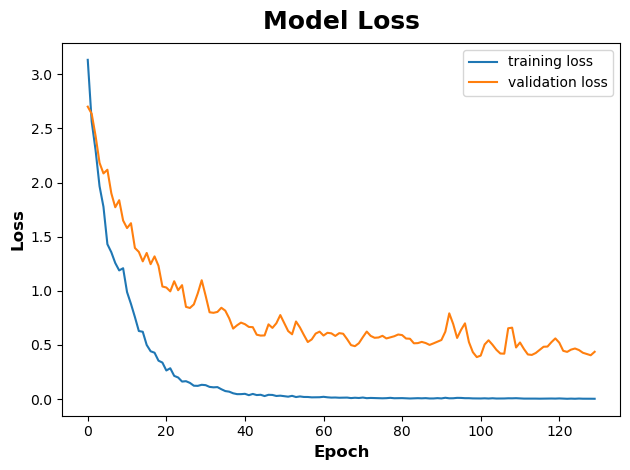

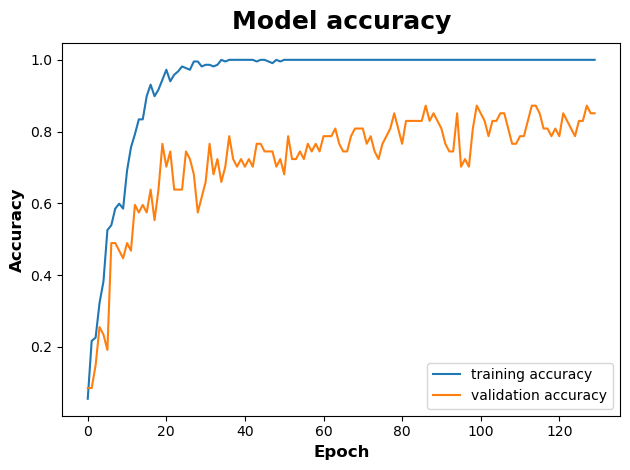

In [252]:
# Make a pandas dataframe so plots can be made from the model
history_frame = pd.DataFrame(history.history)

# Loss curve
history_frame.loc[:, ['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training loss', 'validation loss'])
plt.show()

# Accuracy curve
history_frame.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot();
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training accuracy', 'validation accuracy'])
plt.show()

In [254]:
# metrics of the selected model
history_frame[history_frame.val_loss == history_frame.val_loss.min()]

,categorical_accuracy,loss,val_categorical_accuracy,val_loss
99,1.0,0.005759,0.87234,0.387571


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 554ms/step
['bb = black Bishop', 'bk = black King', 'bn = black Knight', 'bp = black Pawn', 'bq = black Queen', 'br = black Rook', 'wb = white Bishop', 'wk = white King', 'wn = white Knight', 'wp = white Pawn', 'wq = white Queen', 'wr = white Rook']


['bb = black Bishop',
 'bk = black King',
 'bn = black Knight',
 'bp = black Pawn',
 'bq = black Queen',
 'br = black Rook',
 'wb = white Bishop',
 'wk = white King',
 'wn = white Knight',
 'wp = white Pawn',
 'wq = white Queen',
 'wr = white Rook']

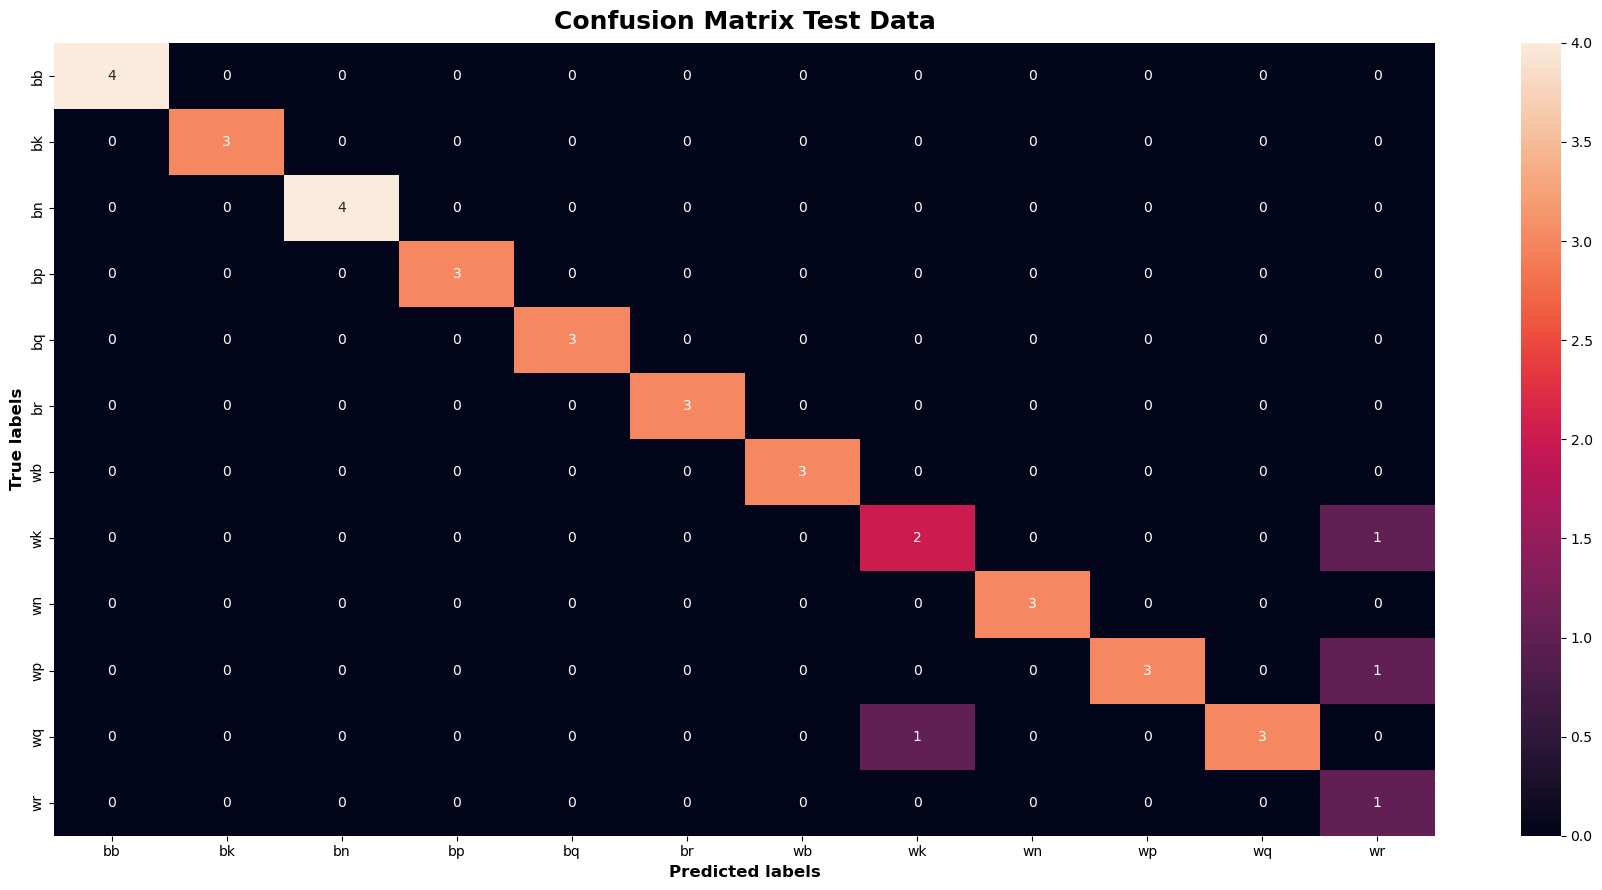

In [264]:
# Get the labels from the test data
array_test = get_labels_from_tfdataset(ds_test)
# Get the class probabilities from the model prediction on the test data
y_pred_test_prob = model.predict(ds_test)
# Use the class probabilities from the model prediction to get class predictions
y_pred_test = np.argmax(y_pred_test_prob, axis=1)

# Get the true values of the training data
y_true_test = np.argmax(array_test,axis=1)

# Create a confusion matrix of the true classes compared to the predicted classes
cm_test = confusion_matrix(y_pred_test, y_true_test)

# now we plot the confusion matrix for the test data
plt.figure(figsize=(18,9))
ax_test = plt.subplot()
# annot=True to annotate cells, ftm='g' to disable scientific notation
sns.heatmap(cm_test, annot=True, fmt='g', ax=ax_test);

# labels, title and ticks
ax_test.set_xlabel('Predicted labels');
ax_test.set_ylabel('True labels'); 
ax_test.set_title('Confusion Matrix Test Data');
ax_test.xaxis.set_ticklabels(['bb', 'bk', "bn", "bp", "bq", "br", "wb", "wk", "wn", "wp", "wq", "wr"]);
ax_test.yaxis.set_ticklabels(['bb', 'bk', "bn", "bp", "bq", "br", "wb", "wk", "wn", "wp", "wq", "wr"]);


# This serves as a legend which is too big for the plot
print(['bb = black Bishop', 'bk = black King', "bn = black Knight",
                "bp = black Pawn", "bq = black Queen", "br = black Rook", 
                "wb = white Bishop", "wk = white King",
                "wn = white Knight","wp = white Pawn", "wq = white Queen",
                "wr = white Rook"])
['bb = black Bishop', 'bk = black King', 'bn = black Knight', 'bp = black Pawn', 'bq = black Queen', 'br = black Rook', 'wb = white Bishop', 'wk = white King', 'wn = white Knight', 'wp = white Pawn', 'wq = white Queen', 'wr = white Rook']

In [266]:
# Creating a list of all the possible classes
target_names = ['black Bishop', 'black King', "black Knight",
                "black Pawn", "black Queen", "black Rook",
                " white Bishop", "white King",
                "white Knight","white Pawn", "white Queen",
                "white Rook"]

# Making a classifcation report on the test data
print(classification_report(y_pred_test, y_true_test, target_names = target_names, digits = 4))
# Printing the overall accuracy of the model on the test data
print("total accuracy",accuracy_score(y_pred_test, y_true_test))

               precision    recall  f1-score   support

 black Bishop     1.0000    1.0000    1.0000         4
   black King     1.0000    1.0000    1.0000         3
 black Knight     1.0000    1.0000    1.0000         4
   black Pawn     1.0000    1.0000    1.0000         3
  black Queen     1.0000    1.0000    1.0000         3
   black Rook     1.0000    1.0000    1.0000         3
 white Bishop     1.0000    1.0000    1.0000         3
   white King     0.6667    0.6667    0.6667         3
 white Knight     1.0000    1.0000    1.0000         3
   white Pawn     1.0000    0.7500    0.8571         4
  white Queen     1.0000    0.7500    0.8571         4
   white Rook     0.3333    1.0000    0.5000         1

     accuracy                         0.9211        38
    macro avg     0.9167    0.9306    0.9067        38
 weighted avg     0.9561    0.9211    0.9305        38

total accuracy 0.9210526315789473
